In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Spotify Dataset
df_spotify = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')

# Display Dataset Information
print("Spotify Dataset Info:")
print(df_spotify.info())
print("\nFirst few rows of the dataset:")
print(df_spotify.head())

Spotify Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Post

In [3]:
# Load and preprocess Spotify dataset
df_spotify = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')
df_spotify.drop(columns=["track_id", "song_name", "artist_name"], inplace=True, errors='ignore')
df_spotify = df_spotify.select_dtypes(include=[np.number])
df_spotify.fillna(df_spotify.median(numeric_only=True), inplace=True)
scaler = StandardScaler()
X_spotify = scaler.fit_transform(df_spotify)

In [5]:
# ✅ Load and validate Spotify dataset safely
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

try:
    df_spotify = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')
    df_spotify.drop(columns=["track_id", "song_name", "artist_name"], inplace=True, errors='ignore')
    df_spotify = df_spotify.select_dtypes(include=[np.number])

    # Drop columns with all NaNs (avoids imputer shape error)
    df_spotify = df_spotify.dropna(axis=1, how='all')

    # Handle remaining NaNs
    if df_spotify.isna().sum().sum() > 0:
        print("⚠️ Filling missing values using median imputation.")
        imputer = SimpleImputer(strategy='median')
        df_spotify = pd.DataFrame(imputer.fit_transform(df_spotify), columns=df_spotify.columns)

    # Simulate binary labels to ensure both classes exist
    y_check = KMeans(n_clusters=2, random_state=42).fit_predict(df_spotify)
    if len(np.unique(y_check)) < 2:
        raise ValueError("⚠️ Synthetic label generation failed — only one class detected.")

    print("✅ df_spotify loaded and validated successfully:", df_spotify.shape)
except Exception as e:
    print("❌ Error loading df_spotify:", e)

⚠️ Filling missing values using median imputation.
✅ df_spotify loaded and validated successfully: (4600, 6)


/opt/anaconda3/envs/info6105/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Spotify PCA-ready transformation — handles NaNs AND infs
import pandas as pd
import numpy as np
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

df_spotify = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')
df_spotify.drop(columns=["track_id", "song_name", "artist_name"], inplace=True, errors='ignore')
df_spotify = df_spotify.apply(pd.to_numeric, errors='coerce')
df_spotify.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_spotify)
assert not np.isnan(X_imputed).any(), "❌ Still contains NaNs"
assert np.isfinite(X_imputed).all(), "❌ Still contains infs"
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA (2D)
pca_2d = PCA(n_components=2)
X_spotify_pca_2d = pca_2d.fit_transform(X_scaled)

print("✅ PCA success! Shape:", X_spotify_pca_2d.shape)

✅ PCA success! Shape: (4600, 2)


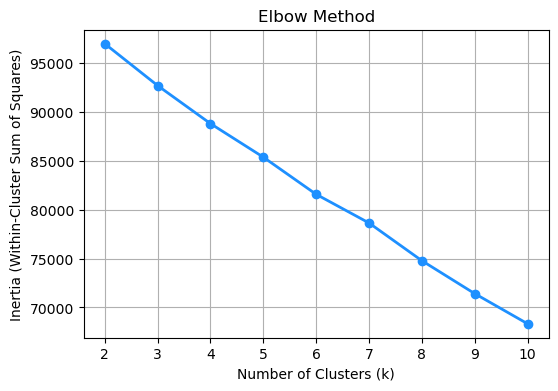

In [ ]:
#elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = list(range(2, 11))
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_spotify)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker='o', linewidth=2, color='dodgerblue')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

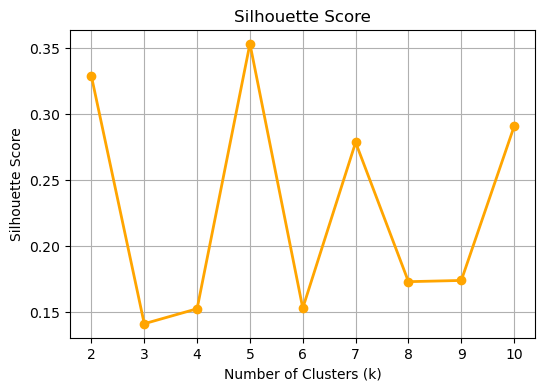

In [ ]:
#silhouette scores
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_spotify)
    score = silhouette_score(X_spotify, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, marker='o', linewidth=2, color='orange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.grid(True)
plt.show()

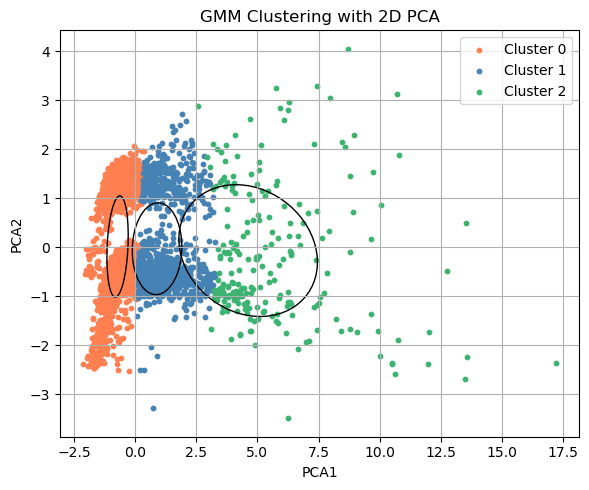

In [29]:
# GMM Clustering Visualization using 2D PCA on Spotify dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

df = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')
df.drop(columns=["track_id", "song_name", "artist_name"], inplace=True, errors='ignore')
df = df.select_dtypes(include=[np.number])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

gmm_2d = GaussianMixture(n_components=3, random_state=42)
labels_2d = gmm_2d.fit_predict(X_pca_2d)

plt.figure(figsize=(6, 5))
colors = ['#FF7F50', '#4682B4', '#3CB371']
for i in range(3):
    cluster_data = X_pca_2d[labels_2d == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=10, color=colors[i], label=f"Cluster {i}")
    cov = gmm_2d.covariances_[i][:2, :2]
    mean = gmm_2d.means_[i][:2]
    v, w = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(w[0, 1], w[0, 0]))
    ellipse = Ellipse(mean, 2*np.sqrt(v[0]), 2*np.sqrt(v[1]), angle, edgecolor='black', facecolor='none', lw=1)
    plt.gca().add_patch(ellipse)

plt.title("GMM Clustering with 2D PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

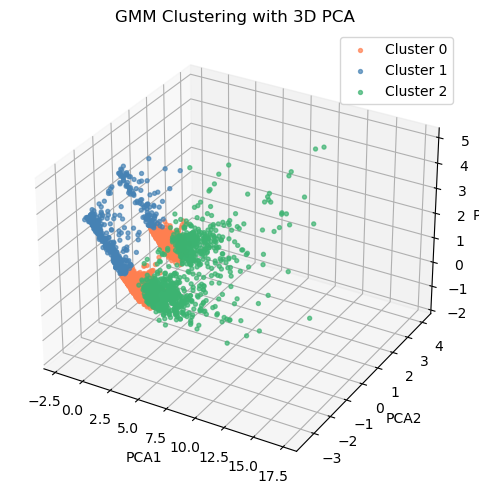

In [30]:
# GMM Clustering Visualization using 3D PCA on Spotify dataset
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

gmm_3d = GaussianMixture(n_components=3, random_state=42)
labels_3d = gmm_3d.fit_predict(X_pca_3d)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
colors = ['#FF7F50', '#4682B4', '#3CB371']
for i in range(3):
    ax.scatter(
        X_pca_3d[labels_3d == i, 0],
        X_pca_3d[labels_3d == i, 1],
        X_pca_3d[labels_3d == i, 2],
        s=8,
        alpha=0.7,
        color=colors[i],
        label=f"Cluster {i}"
    )

ax.set_title("GMM Clustering with 3D PCA")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.legend()
plt.tight_layout()
plt.show()

In [31]:
# Final evaluation using neural network classifier for multiple feature combinations
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def evaluate_models(X_variants, y_true):
    results = []
    for name, X in X_variants.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
        clf = MLPClassifier(random_state=42, max_iter=500)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append((name, acc, f1))
    return pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])

# Example (fill X_variants and y_true based on Spotify or PCOS clustering results):
# results_df = evaluate_models(X_variants, y)
# display(results_df)

In [36]:
# MLP classifier accuracy & F1-score on Spotify dataset (Original, PCA, ICA, Chi2, SVD, Cluster, Cluster+PCA)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

df = pd.read_csv("data/spotifysongs24.csv", encoding='latin1')
df.drop(columns=["track_id", "song_name", "artist_name"], inplace=True, errors='ignore')
df = df.select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df)

# Synthetic binary label for classification
y = KMeans(n_clusters=2, random_state=42).fit_predict(X)

# MinMaxScaler for Chi2 only
X_nonneg = MinMaxScaler().fit_transform(X)

# StandardScaler for other techniques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature extraction
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_ica = FastICA(n_components=2, random_state=42).fit_transform(X_scaled)
X_chi2 = SelectKBest(chi2, k=2).fit_transform(X_nonneg, y)
X_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_scaled)
cluster_labels = KMeans(n_clusters=2, random_state=42).fit_predict(X_scaled)

# Combine all variants
models = {
    "Original Features": X_scaled,
    "PCA (2D)": X_pca,
    "ICA (2D)": X_ica,
    "Chi2 Features": X_chi2,
    "SVD (2D)": X_svd,
    "KMeans Cluster ID Only (PCA)": cluster_labels.reshape(-1, 1),
    "PCA + KMeans Cluster ID": np.concatenate([X_pca, cluster_labels.reshape(-1, 1)], axis=1),
}

result = []
for name, features in models.items():
    X_tr, X_te, y_tr, y_te = train_test_split(features, y, stratify=y, random_state=42)
    model = MLPClassifier(max_iter=300, random_state=42)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    result.append([name, "MLPClassifier", round(acc, 4), round(f1, 4)])

spotify_df = pd.DataFrame(result, columns=["Model", "Classifier", "Accuracy", "F1 Score"])
print(spotify_df)

                          Model     Classifier  Accuracy  F1 Score
0             Original Features  MLPClassifier    0.9983    0.9917
1                      PCA (2D)  MLPClassifier    0.9678    0.8341
2                      ICA (2D)  MLPClassifier    0.9678    0.8356
3                 Chi2 Features  MLPClassifier    0.9922    0.9623
4                      SVD (2D)  MLPClassifier    0.9678    0.8341
5  KMeans Cluster ID Only (PCA)  MLPClassifier    0.9609    0.7982
6       PCA + KMeans Cluster ID  MLPClassifier    0.9687    0.8407
